In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw3.ok')

Assignment: hw3
OK, version v1.13.11



# Homework 3: Trump, Twitter, and Text

## Due Date: Monday 2/25, 11:59 pm PST

Welcome to the third homework assignment of Data 100/200! In this assignment, we will work with Twitter data in order to analyze Donald Trump's tweets.

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** below.

**Collaborators**: *list collaborators here*

In [2]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile

# Ensure that Pandas shows at least 280 characters in columns, so we can see full tweets
pd.set_option('max_colwidth', 280)

%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

### Score Breakdown

Question | Points
--- | ---
Question 1 | 2
Question 2 | 1
Question 3 | 2
Question 4a | 1
Question 4b | 2
Question 4c | 2
Question 5a | 1
Question 5b | 1
Question 5c | 1
Question 5d | 2
Question 5e | 2
Question 6a | 1
Question 6b | 1
Total | 19

---
# Part 1: Importing the Data

We will again use the `fetch_and_cache` utility to download the dataset. 

In [3]:
# Download the dataset
from ds100_utils import fetch_and_cache
data_url = 'http://www.ds100.org/sp19/assets/datasets/hw3-realdonaldtrump_tweets.json.zip'
file_name = 'hw3-realdonaldtrump_tweets.json.zip'

dest_path = fetch_and_cache(data_url=data_url, file=file_name)
print(f'Located at {dest_path}')

Using version already downloaded: Sat Feb 23 11:48:17 2019
MD5 hash of file: f26e90f51b3d7b304d8db1ad5bee2f57
Located at data/hw3-realdonaldtrump_tweets.json.zip


Now that we've downloaded the tweets, let's unzip them and load them into our notebook. Run the cell below to unzip and read tweets from the json file into a list named `all_tweets`.

In [4]:
# Unzip the dataset
my_zip = zipfile.ZipFile(dest_path, 'r')
with my_zip.open('hw3-realdonaldtrump_tweets.json', 'r') as f:
    all_tweets = json.load(f)

Here is what a typical tweet from `all_tweets` looks like:

In [5]:
from pprint import pprint # to get a more easily-readable view.
pprint(all_tweets[-1])

{'contributors': None,
 'coordinates': None,
 'created_at': 'Tue Oct 16 18:40:18 +0000 2018',
 'display_text_range': [0, 174],
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 52115,
 'favorited': False,
 'full_text': 'Just spoke with the Crown Prince of Saudi Arabia who totally '
              'denied any knowledge of what took place in their Turkish '
              'Consulate. He was with Secretary of State Mike Pompeo...',
 'geo': None,
 'id': 1052268011900555265,
 'id_str': '1052268011900555265',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'retweet_count': 13493,
 'retweeted': False,
 'source': '<a href="http://twitter.com/download/iphone" '
           'rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'user': {'contributors_enabled': False,
  

## Question 1

Construct a DataFrame called `trump` containing data from all the tweets stored in `all_tweets`. The index of the DataFrame should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created encoded as a datetime object. (Use `pd.to_datetime` to encode the timestamp.)
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

Finally, **the resulting DataFrame should be sorted by the index.**

**Warning:** *Some tweets will store the text in the `text` field and other will use the `full_text` field.*

<!--
BEGIN QUESTION
name: q1
points: 2
-->

In [6]:
trump = pd.DataFrame(all_tweets).loc[:, ['id', 'created_at', 'source', 'full_text', 'text', 'retweet_count']]
trump['combined_text'] = trump.fillna('')['full_text'] + trump.fillna('')['text']
trump = trump.loc[:, ['id', 'created_at', 'source', 'combined_text', 'retweet_count']]
trump = trump.rename({'id':'ID', 'created_at':'time', 'source':'source', 'combined_text':'text', 'retweet_count':'retweet_count'}, axis='columns')
trump = trump.sort_values(by=['ID']).set_index('ID')
trump['time'] = pd.to_datetime(trump['time'])
trump.loc[884740553040175104]

time                                                                            2017-07-11 11:46:00
source           <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
text                     Working hard to get the Olympics for the United States (L.A.). Stay tuned!
retweet_count                                                                                 20120
Name: 884740553040175104, dtype: object

In [7]:
ok.grade("q1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 9
    Failed: 0
[ooooooooook] 100.0% passed



---
# Part 2: Tweet Source Analysis

In the following questions, we are going to find out the charateristics of Trump tweets and the devices used for the tweets.

First let's examine the source field:

In [8]:
trump['source'].unique()

array(['<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
       '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M5)</a>',
       '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
       '<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Media Studio</a>',
       '<a href="https://periscope.tv" rel="nofollow">Periscope</a>',
       '<a href="https://ads.twitter.com" rel="nofollow">Twitter Ads</a>',
       '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>'],
      dtype=object)

## Question 2

Notice how sources like "Twitter for Android" or "Instagram" are surrounded by HTML tags. In the cell below, clean up the `source` field by removing the HTML tags from each `source` entry.

**Hints:** 
* Use `trump['source'].str.replace` along with a regular expression.
* You may find it helpful to experiment with regular expressions at [regex101.com](https://regex101.com/).

<!--
BEGIN QUESTION
name: q2
points: 1
-->

In [9]:
## Uncomment and complete
trump['source'] = trump['source'].str.replace('<[^>]+>', '')
trump.head()

,time,source,text,retweet_count
ID,,,,
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339
690173226341691392,2016-01-21 14:04:54,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266
690180284189310976,2016-01-21 14:32:57,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886


In [10]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



In the following plot, we see that there are two device types that are more commonly used than others.

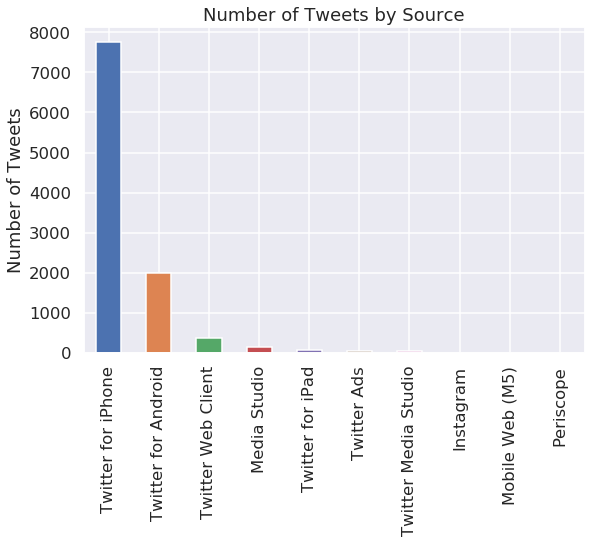

In [11]:
plt.figure(figsize=(8, 6))
trump['source'].value_counts().plot(kind="bar")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets by Source");

## Question 3

Now that we have cleaned up the `source` field, let's now look at which device Trump has used over the entire time period of this dataset.

To examine the distribution of dates we will convert the date to a fractional year that can be plotted as a distribution.

(Code borrowed from https://stackoverflow.com/questions/6451655/python-how-to-convert-datetime-dates-to-decimal-years)

In [12]:
import datetime
def year_fraction(date):
    start = datetime.date(date.year, 1, 1).toordinal()
    year_length = datetime.date(date.year+1, 1, 1).toordinal() - start
    return date.year + float(date.toordinal() - start) / year_length

trump['year'] = trump['time'].apply(year_fraction)

Now, use `sns.distplot` to overlay the distributions of Trump's 2 most frequently used web technologies over the years. Your final plot should look like:

<img src="images/source_years_q3.png" width="600px" />

<!--
BEGIN QUESTION
name: q3
points: 2
manual: true
-->
<!-- EXPORT TO PDF -->

/srv/conda/envs/data100/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


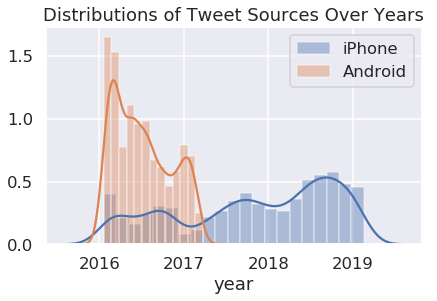

In [13]:
android_source = trump.loc[trump['source'] == 'Twitter for Android']
iphone_source = trump.loc[trump['source'] == 'Twitter for iPhone']
_ = sns.distplot(iphone_source['year'])
_ = sns.distplot(android_source['year'])
_ = plt.legend(['iPhone', 'Android'])
_ = plt.title('Distributions of Tweet Sources Over Years')

## Question 4


Is there a difference between Trump's tweet behavior across these devices? We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android device come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets) (notice the `+0000` in the first few tweets).

In [14]:
for tweet in all_tweets[:3]:
    print(tweet['created_at'])

Wed Oct 12 14:00:48 +0000 2016
Wed Oct 12 13:46:43 +0000 2016
Wed Oct 12 12:59:05 +0000 2016


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [15]:
trump['est_time'] = (
    trump['time'].dt.tz_localize("UTC") # Set initial timezone to UTC
                 .dt.tz_convert("EST") # Convert to Eastern Time
)
trump.head()

,time,source,text,retweet_count,year,est_time
ID,,,,,,
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059,2016.054645,2016-01-21 08:56:11-05:00
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339,2016.054645,2016-01-21 08:57:39-05:00
690173226341691392,2016-01-21 14:04:54,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006,2016.054645,2016-01-21 09:04:54-05:00
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266,2016.054645,2016-01-21 09:19:26-05:00
690180284189310976,2016-01-21 14:32:57,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886,2016.054645,2016-01-21 09:32:57-05:00


### Question 4a

Add a column called `hour` to the `trump` table which contains the hour of the day as floating point number computed by:

$$
\text{hour} + \frac{\text{minute}}{60} + \frac{\text{second}}{60^2}
$$

* **Hint:** See the cell above for an example of working with [dt accessors](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html#basics-dt-accessors).

<!--
BEGIN QUESTION
name: q4a
points: 1
-->

In [16]:
trump['hour'] = trump['est_time'].dt.hour + (trump['est_time'].dt.minute)/60 + (trump['est_time'].dt.second)/(60**2)
trump.head()

,time,source,text,retweet_count,year,est_time,hour
ID,,,,,,,
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realDonaldTrump @SarahPalinUSA https://t.co/3kYQGqeVyD""",1059,2016.054645,2016-01-21 08:56:11-05:00,8.936389
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@AmericanAsPie: @glennbeck @SarahPalinUSA Remember when Glenn gave out gifts to ILLEGAL ALIENS at crossing the border? Me too!""",1339,2016.054645,2016-01-21 08:57:39-05:00,8.960833
690173226341691392,2016-01-21 14:04:54,Twitter for Android,So sad that @CNN and many others refused to show the massive crowd at the arena yesterday in Oklahoma. Dishonest reporting!,2006,2016.054645,2016-01-21 09:04:54-05:00,9.081667
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"Sad sack @JebBush has just done another ad on me, with special interest money, saying I won't beat Hillary - I WILL. But he can't beat me.",2266,2016.054645,2016-01-21 09:19:26-05:00,9.323889
690180284189310976,2016-01-21 14:32:57,Twitter for Android,Low energy candidate @JebBush has wasted $80 million on his failed presidential campaign. Millions spent on me. He should go home and relax!,2886,2016.054645,2016-01-21 09:32:57-05:00,9.549167


In [17]:
ok.grade("q4a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 4b

Use this data along with the seaborn `distplot` function to examine the distribution over hours of the day in eastern time that trump tweets on each device for the 2 most commonly used devices.  Your plot should look similar to the following:

<img src="images/device_hour4b.png" width="600px" />

<!--
BEGIN QUESTION
name: q4b
points: 2
manual: true
-->
<!-- EXPORT TO PDF -->

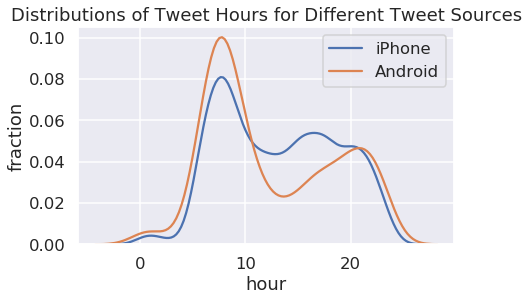

In [18]:
### make your plot here
android_hour = trump.loc[trump['source'] == 'Twitter for Android']
iphone_hour = trump.loc[trump['source'] == 'Twitter for iPhone']
_ = sns.distplot(iphone_hour['hour'], hist=False, label='iPhone')
_ = sns.distplot(android_hour['hour'], hist=False, label='Android')
_ = plt.legend()
_ = plt.ylabel('fraction')
_ = plt.title('Distributions of Tweet Hours for Different Tweet Sources')

### Question 4c

According to [this Verge article](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android), Donald Trump switched from an Android to an iPhone sometime in March 2017.

Let's see if this information significantly changes our plot. Create a figure similar to your figure from question 4b, but this time, only use tweets that were tweeted before 2017. Your plot should look similar to the following:

<img src="images/device_hour4c.png" width="600px" />

<!--
BEGIN QUESTION
name: q4c
points: 2
manual: true
-->
<!-- EXPORT TO PDF -->

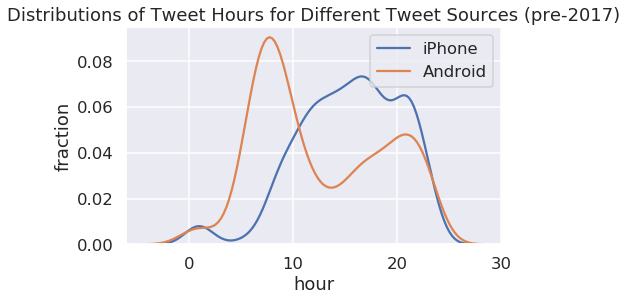

In [19]:
### make your plot here
android_hour_2 = trump.loc[(trump['source'] == 'Twitter for Android') & (trump['year'] < 2017)]
iphone_hour_2 = trump.loc[(trump['source'] == 'Twitter for iPhone') & (trump['year'] < 2017)]
_ = sns.distplot(iphone_hour_2['hour'], hist=False, label='iPhone')
_ = sns.distplot(android_hour_2['hour'], hist=False, label='Android')
_ = plt.legend()
_ = plt.ylabel('fraction')
_ = plt.title('Distributions of Tweet Hours for Different Tweet Sources (pre-2017)')

### Question 4d

During the campaign, it was theorized that Donald Trump's tweets from Android devices were written by him personally, and the tweets from iPhones were from his staff. Does your figure give support to this theory? What kinds of additional analysis could help support or reject this claim?

<!--
BEGIN QUESTION
name: q4d
points: 1
manual: true
-->
<!-- EXPORT TO PDF -->

I belive the plot above supports this theory because there is a decrease in tweets from his Android during working hours, between 8am to 8pm, whereas there is an increase in tweets from his iPhone during the same time period. This observation reasonbly supports the theory because staff members will likely be 'working' during the times they post tweets for Trump and Trump most likely has more time for personal tweets when he is away from work. In order to better support or reject this claim, we could, for instance, observe source behavior during holidays or weekends.

---
# Part 3: Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [20]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



## Question 5

As you can see, the lexicon contains emojis too! Each row contains a word and the *polarity* of that word, measuring how positive or negative the word is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

### Question 5a

Read in the lexicon into a DataFrame called `sent`. The index of the DataFrame should be the words in the lexicon. `sent` should have one column named `polarity`, storing the polarity of each word.

* **Hint:** The `pd.read_csv` function may help here. 

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [21]:
sent = pd.read_csv('vader_lexicon.txt', sep='\t', header=None).loc[:, [0, 1]]
sent = sent.rename({0:'word', 1:'polarity'}, axis='columns').set_index('word')
sent.head()

,polarity
word,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


In [22]:
ok.grade("q5a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5b

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DataFrame to be the lowercased text of each tweet.

<!--
BEGIN QUESTION
name: q5b
points: 1
-->

In [23]:
trump['text'] = trump['text'].str.lower()
trump.head()

,time,source,text,retweet_count,year,est_time,hour
ID,,,,,,,
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realdonaldtrump @sarahpalinusa https://t.co/3kyqgqevyd""",1059,2016.054645,2016-01-21 08:56:11-05:00,8.936389
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@americanaspie: @glennbeck @sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border? me too!""",1339,2016.054645,2016-01-21 08:57:39-05:00,8.960833
690173226341691392,2016-01-21 14:04:54,Twitter for Android,so sad that @cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma. dishonest reporting!,2006,2016.054645,2016-01-21 09:04:54-05:00,9.081667
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"sad sack @jebbush has just done another ad on me, with special interest money, saying i won't beat hillary - i will. but he can't beat me.",2266,2016.054645,2016-01-21 09:19:26-05:00,9.323889
690180284189310976,2016-01-21 14:32:57,Twitter for Android,low energy candidate @jebbush has wasted $80 million on his failed presidential campaign. millions spent on me. he should go home and relax!,2886,2016.054645,2016-01-21 09:32:57-05:00,9.549167


In [24]:
ok.grade("q5b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5c

Now, let's get rid of punctuation since it will cause us to fail to match words. Create a new column called `no_punc` in the `trump` DataFrame to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be *any character that isn't a Unicode word character or a whitespace character*. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)

<!--
BEGIN QUESTION
name: q5c
points: 1
-->

In [25]:
# Save your regex in punct_re
punct_re = r'[^\w\s]'
trump['no_punc'] = trump['text'].replace(punct_re, ' ', regex=True)

trump

,time,source,text,retweet_count,year,est_time,hour,no_punc
ID,,,,,,,,
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realdonaldtrump @sarahpalinusa https://t.co/3kyqgqevyd""",1059,2016.054645,2016-01-21 08:56:11-05:00,8.936389,bigop1 realdonaldtrump sarahpalinusa https t co 3kyqgqevyd
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@americanaspie: @glennbeck @sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border? me too!""",1339,2016.054645,2016-01-21 08:57:39-05:00,8.960833,americanaspie glennbeck sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border me too
690173226341691392,2016-01-21 14:04:54,Twitter for Android,so sad that @cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma. dishonest reporting!,2006,2016.054645,2016-01-21 09:04:54-05:00,9.081667,so sad that cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma dishonest reporting
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"sad sack @jebbush has just done another ad on me, with special interest money, saying i won't beat hillary - i will. but he can't beat me.",2266,2016.054645,2016-01-21 09:19:26-05:00,9.323889,sad sack jebbush has just done another ad on me with special interest money saying i won t beat hillary i will but he can t beat me
690180284189310976,2016-01-21 14:32:57,Twitter for Android,low energy candidate @jebbush has wasted $80 million on his failed presidential campaign. millions spent on me. he should go home and relax!,2886,2016.054645,2016-01-21 09:32:57-05:00,9.549167,low energy candidate jebbush has wasted 80 million on his failed presidential campaign millions spent on me he should go home and relax
690271688127213568,2016-01-21 20:36:09,Twitter for iPhone,new day on cnn treats me very badly. @alisyncamerota is a disaster. not going to watch anymore.,1429,2016.054645,2016-01-21 15:36:09-05:00,15.602500,new day on cnn treats me very badly alisyncamerota is a disaster not going to watch anymore
690272687168458754,2016-01-21 20:40:07,Twitter for Android,"happy birthday to my friend, the great @jacknicklaus - a totally special guy!",1053,2016.054645,2016-01-21 15:40:07-05:00,15.668611,happy birthday to my friend the great jacknicklaus a totally special guy
690313350278819840,2016-01-21 23:21:42,Twitter for iPhone,"thank you, iowa! #trump2016 https://t.co/ryhehetlqn",2329,2016.054645,2016-01-21 18:21:42-05:00,18.361667,thank you iowa trump2016 https t co ryhehetlqn
690315202261155840,2016-01-21 23:29:04,Twitter for iPhone,thank you! #trump2016 https://t.co/pcdmyio1zt,1463,2016.054645,2016-01-21 18:29:04-05:00,18.484444,thank you trump2016 https t co pcdmyio1zt


In [26]:
ok.grade("q5c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 10
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5d

Now, let's convert the tweets into what's called a [*tidy format*](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

The first few rows of our `tidy_format` table look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>num</th>
      <th>word</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>894661651760377856</th>
      <td>0</td>
      <td>i</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>1</td>
      <td>think</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>2</td>
      <td>senator</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>3</td>
      <td>blumenthal</td>
    </tr>
    <tr>
      <th>894661651760377856</th>
      <td>4</td>
      <td>should</td>
    </tr>
  </tbody>
</table>

**Note that your DataFrame may look different from the one above.** However, you can double check that your tweet with ID `894661651760377856` has the same rows as ours. Our tests don't check whether your table looks exactly like ours.

As usual, try to avoid using any for loops. Our solution uses a chain of 5 methods on the `trump` DataFrame, albeit using some rather advanced Pandas hacking.

* **Hint 1:** Try looking at the `expand` argument to pandas' `str.split`.

* **Hint 2:** Try looking at the `stack()` method.

* **Hint 3:** Try looking at the `level` parameter of the `reset_index` method.

<!--
BEGIN QUESTION
name: q5d
points: 2
-->

In [27]:
tidy_format = trump[['no_punc']]
tidy_format = tidy_format['no_punc'].str.split(expand=True)
tidy_format = tidy_format.stack()
tidy_format = tidy_format.reset_index(level=1).rename({'level_1':'num', 0:'word'}, axis='columns')
tidy_format.head()

,num,word
ID,,
690171032150237184,0,bigop1
690171032150237184,1,realdonaldtrump
690171032150237184,2,sarahpalinusa
690171032150237184,3,https
690171032150237184,4,t


In [28]:
ok.grade("q5d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5e

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. 

Add a `polarity` column to the `trump` table.  The `polarity` column should contain the sum of the sentiment polarity of each word in the text of the tweet.

**Hints:** 
* You will need to merge the `tidy_format` and `sent` tables and group the final answer.
* If certain words are not found in the `sent` table, set their polarities to 0.

<!--
BEGIN QUESTION
name: q5e
points: 2
-->

In [29]:
temp = pd.merge(tidy_format.reset_index(), sent, how='left', on='word').set_index('ID')
temp = temp.groupby('ID').sum()[['polarity']]

trump = pd.merge(trump.reset_index(), temp.reset_index(), how='left', on='ID').set_index('ID')
trump.head()

,time,source,text,retweet_count,year,est_time,hour,no_punc,polarity
ID,,,,,,,,,
690171032150237184,2016-01-21 13:56:11,Twitter for Android,"""@bigop1: @realdonaldtrump @sarahpalinusa https://t.co/3kyqgqevyd""",1059,2016.054645,2016-01-21 08:56:11-05:00,8.936389,bigop1 realdonaldtrump sarahpalinusa https t co 3kyqgqevyd,0.0
690171403388104704,2016-01-21 13:57:39,Twitter for Android,"""@americanaspie: @glennbeck @sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border? me too!""",1339,2016.054645,2016-01-21 08:57:39-05:00,8.960833,americanaspie glennbeck sarahpalinusa remember when glenn gave out gifts to illegal aliens at crossing the border me too,-2.6
690173226341691392,2016-01-21 14:04:54,Twitter for Android,so sad that @cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma. dishonest reporting!,2006,2016.054645,2016-01-21 09:04:54-05:00,9.081667,so sad that cnn and many others refused to show the massive crowd at the arena yesterday in oklahoma dishonest reporting,-6.0
690176882055114758,2016-01-21 14:19:26,Twitter for Android,"sad sack @jebbush has just done another ad on me, with special interest money, saying i won't beat hillary - i will. but he can't beat me.",2266,2016.054645,2016-01-21 09:19:26-05:00,9.323889,sad sack jebbush has just done another ad on me with special interest money saying i won t beat hillary i will but he can t beat me,4.3
690180284189310976,2016-01-21 14:32:57,Twitter for Android,low energy candidate @jebbush has wasted $80 million on his failed presidential campaign. millions spent on me. he should go home and relax!,2886,2016.054645,2016-01-21 09:32:57-05:00,9.549167,low energy candidate jebbush has wasted 80 million on his failed presidential campaign millions spent on me he should go home and relax,-2.6


In [30]:
ok.grade("q5e");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 6
    Failed: 0
[ooooooooook] 100.0% passed



Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [31]:
print('Most negative tweets:')
for t in trump.sort_values('polarity').head()['text']:
    print('\n  ', t)

Most negative tweets:

   the trump portrait of an unsustainable border crisis is dead on. “in the last two years, ice officers made 266,000 arrests of aliens with criminal records, including those charged or convicted of 100,000 assaults, 30,000 sex crimes &amp; 4000 violent killings.” america’s southern....

   it is outrageous that poisonous synthetic heroin fentanyl comes pouring into the u.s. postal system from china. we can, and must, end this now! the senate should pass the stop act – and firmly stop this poison from killing our children and destroying our country. no more delay!

   the rigged russian witch hunt goes on and on as the “originators and founders” of this scam continue to be fired and demoted for their corrupt and illegal activity. all credibility is gone from this terrible hoax, and much more will be lost as it proceeds. no collusion!

   ...this evil anti-semitic attack is an assault on humanity. it will take all of us working together to extract the poison of an

In [32]:
print('Most positive tweets:')
for t in trump.sort_values('polarity', ascending=False).head()['text']:
    print('\n  ', t)

Most positive tweets:

   congratulations to patrick reed on his great and courageous masters win! when patrick had his amazing win at doral 5 years ago, people saw his great talent, and a bright future ahead. now he is the masters champion!

   congratulations to a truly great football team, the clemson tigers, on an incredible win last night against a powerful alabama team. a big win also for the great state of south carolina. look forward to seeing the team, and their brilliant coach, for the second time at the w.h.

   my supporters are the smartest, strongest, most hard working and most loyal that we have seen in our countries history. it is a beautiful thing to watch as we win elections and gather support from all over the country. as we get stronger, so does our country. best numbers ever!

   thank you to all of my great supporters, really big progress being made. other countries wanting to fix crazy trade deals. economy is roaring. supreme court pick getting great reviews. new

## Question 6

Now, let's try looking at the distributions of sentiments for tweets containing certain keywords.

### Question 6a

In the cell below, create a single plot showing both the distribution of tweet sentiments for tweets containing `nytimes`, as well as the distribution of tweet sentiments for tweets containing `fox`.

<!--
BEGIN QUESTION
name: q6a
points: 1
manual: true
-->
<!-- EXPORT TO PDF -->

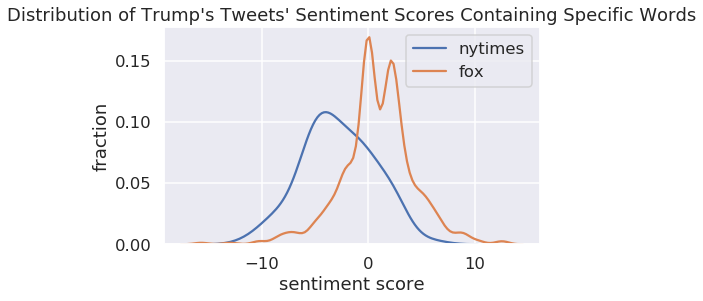

In [33]:
nytimes = trump.loc[trump['no_punc'].str.contains('nytimes')][['polarity']]
fox = trump.loc[trump['no_punc'].str.contains('fox')][['polarity']]
_ = sns.distplot(nytimes, hist=False, label='nytimes')
_ = sns.distplot(fox, hist=False, label='fox')
_ = plt.ylabel('fraction')
_ = plt.xlabel('sentiment score')
_ = plt.title('Distribution of Trump\'s Tweets\' Sentiment Scores Containing Specific Words')
_ = plt.legend()

### Question 6b
Comment on what you observe in the plot above. Can you find other pairs of keywords that lead to interesting plots? (If you modify your code in 6a, remember to change the words back to `nytimes` and `fox` before submitting for grading).

<!--
BEGIN QUESTION
name: q6b
points: 1
manual: true
--><!-- EXPORT TO PDF -->

We're observing relatively positive sentiments (>0) in tweets containing the word 'fox' as opposed to negative sentiments (<0) in tweets contains the word 'nytimes'. It appears that the negative sentiment towards nytimes is stronger than is positive sentiment towards fox. A similar distribution can be observed using keywords such as 'immigrant' and 'america'.

In [34]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('hw3.ipynb', 'hw3.pdf')
ok.submit()

Generating PDF...
Saved hw3.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... 

ERROR  | auth.py:91 | {'error': 'invalid_grant'}


Saved 'hw3.ipynb'.
Performing authentication
Please enter your bCourses email.
bCourses email: damienk@berkeley.edu

Copy the following URL and open it in a web browser. To copy,
highlight the URL, right-click, and select "Copy".

https://okpy.org/client/login/

After logging in, copy the code from the web page, paste it below,
and press Enter. To paste, right-click and select "Paste".

Paste your code here: zAF5PCGUa4FO27Oj8Ar64Puc4QOvWJ
Successfully logged in as damienk@berkeley.edu
Submit... 100% complete
Submission successful for user: damienk@berkeley.edu
URL: https://okpy.org/cal/data100/sp19/hw3/submissions/WLPWvv

